In [1]:
import numpy  as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
import seaborn as sn
from sklearn.model_selection import KFold
from IPython.display import clear_output
import copy

In [2]:
CNNCONFIG=[
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(48, 48, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
]

In [3]:
X,Y=shuffle(
    pd.read_csv('../Data/x_train_gr_smpl.csv').to_numpy(),
    pd.read_csv('../Data/y_train_smpl.csv').to_numpy(),
    random_state=0)
XT,YT=shuffle(
    pd.read_csv('../Data/x_test_gr_smpl.csv').to_numpy()
    ,pd.read_csv('../Data/y_test_smpl.csv').to_numpy(),
    random_state=0)
XR=X.reshape(X.shape[0],48,48,1)/255
XRT=XT.reshape(XT.shape[0],48,48,1)/255

In [4]:
def scores_By_Class(y_actual, y_predicted):
    values=[[None]*4]*10
    f=y_actual.flatten()
    for i in range(10):
        y=(i==f)
        yp=y_predicted==i
        values[i][0]= accuracy_score(y,yp) 
        values[i][1]= precision_score(y,yp)
        values[i][2]= recall_score(y,yp)
        values[i][3]=f1_score(y,yp)
    return values
    
def plot_ROC_NN(y_actual, y_predicted):
    plt.title("ROC curve")
    f=y_actual.flatten()
    for i in range(10):
        fp, tp, th=roc_curve((i==f),y_predicted==i)
        plt.plot(fp,tp, label=i, alpha=0.5)
        plt.axis([0, 1, 0, 1]) 
        plt.legend(loc="lower right")
    plt.xlabel("False Positive")
    plt.ylabel("True Positive")
def plot_Matrix_NN(y_actual, y_predicted):
    plt.title("Confusion Matrix")
    matrix=confusion_matrix(y_actual,y_predicted)
    sn.heatmap(matrix, annot=True, fmt='d',xticklabels=range(10),yticklabels=range(10))
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
def trainTestSplit(X,y,n):
    splits=KFold(n_splits=n).split(X,y)
    count=0
    xtrains,ytrains,xtests,ytests=[[None]*n for f in range(4)]
    for train_index, test_index in splits:
        xtrains[count], xtests[count]=X[train_index],X[test_index]
        ytrains[count],  ytests[count] = Y[train_index], Y[test_index]
        count+=1
    return xtrains,ytrains,xtests,ytests

def KfoldNN(spec,x,y,k=10,epoch=5):
    results=[None]*k
    y_act= np.array([])
    y_pred=np.array([])
    xt,yt,xtst,ytst=trainTestSplit(x,y,k)
    for count in range(k):
        model = tf.keras.models.Sequential(copy.deepcopy(CNNCONFIG))
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        clear_output(wait=True)
        print("KFold: ["+("|"*(count+1))+("."*(k-(count+1)))+"]" )    
        model.fit(xt[count], yt[count], epochs=epoch)
        results[count]=model.evaluate(xtst[count],  ytst[count])[1]
        y_act = np.append(y_act, ytst[count])
        y_pred= np.append(y_pred, np.argmax(model.predict(xtst[count]), axis=1) ) 
        tf.keras.backend.clear_session()
    print("\n{0}-Fold Accuracy: {1}%".format(k,np.round(np.sum(results)/k,4)))
    return (np.sum(results)/k),results,y_act,y_pred

In [5]:
r=KfoldNN(copy.deepcopy(CNNCONFIG),XR,Y,k=10,epoch=5)

KFold: [||||||||||]
Epoch 1/5
8721/8721 [==============================] - 1s 127us/sample - loss: 0.9345 - acc: 0.6729
Epoch 2/5
8721/8721 [==============================] - 1s 120us/sample - loss: 0.1546 - acc: 0.9539
Epoch 3/5
8721/8721 [==============================] - 1s 120us/sample - loss: 0.0769 - acc: 0.9791
Epoch 4/5
8721/8721 [==============================] - 1s 121us/sample - loss: 0.0524 - acc: 0.9852
Epoch 5/5
969/969 [==============================] - 0s 81us/sample - loss: 0.0780 - acc: 0.9773

10-Fold Accuracy: 0.9822%


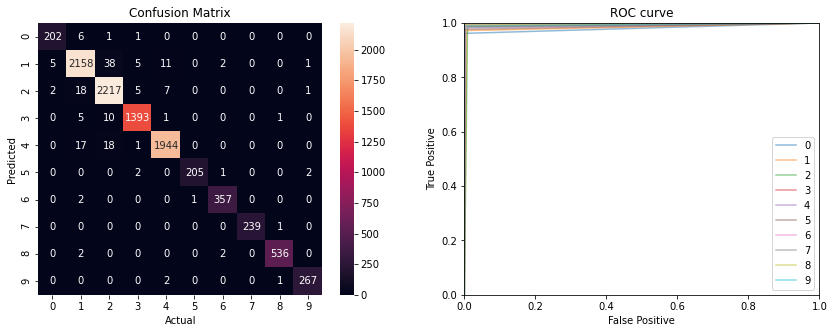

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       210
         1.0       0.98      0.97      0.97      2220
         2.0       0.97      0.99      0.98      2250
         3.0       0.99      0.99      0.99      1410
         4.0       0.99      0.98      0.99      1980
         5.0       1.00      0.98      0.99       210
         6.0       0.99      0.99      0.99       360
         7.0       1.00      1.00      1.00       240
         8.0       0.99      0.99      0.99       540
         9.0       0.99      0.99      0.99       270

    accuracy                           0.98      9690
   macro avg       0.99      0.98      0.98      9690
weighted avg       0.98      0.98      0.98      9690



In [6]:
y_act,y_pred=r[2],r[3]
plt.figure(figsize=(14,5))
plt.subplot(121)
plot_Matrix_NN(y_act,y_pred)
plt.subplot(122)
plot_ROC_NN(y_act,y_pred)
plt.show()
print(classification_report(y_act, y_pred))

In [7]:
model = tf.keras.models.Sequential(copy.deepcopy(CNNCONFIG))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(XR, Y, epochs=5)
test_loss, test_acc = model.evaluate(XRT,  YT, verbose=0)
print('\nTest accuracy:', test_acc)

Epoch 1/5
9690/9690 [==============================] - 1s 133us/sample - loss: 0.9496 - acc: 0.6645
Epoch 2/5
9690/9690 [==============================] - 1s 121us/sample - loss: 0.1304 - acc: 0.9640
Epoch 3/5
9690/9690 [==============================] - 1s 117us/sample - loss: 0.0610 - acc: 0.9844
Epoch 4/5
9690/9690 [==============================] - 1s 120us/sample - loss: 0.0505 - acc: 0.9845
Epoch 5/5
9690/9690 [==============================] - 1s 127us/sample - loss: 0.0368 - acc: 0.9906

Test accuracy: 0.94854367


In [8]:
y_pred = np.argmax(model.predict(XRT), axis=1)

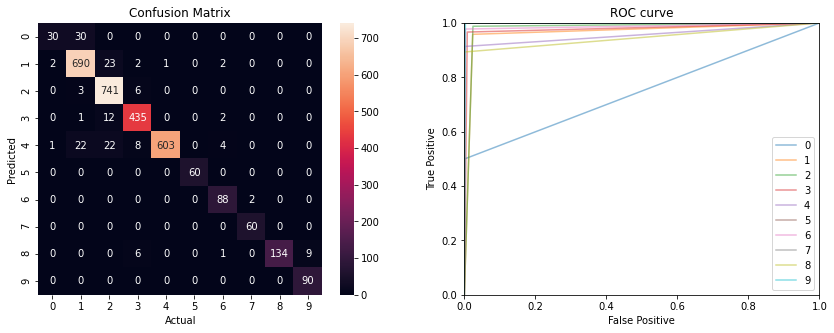

              precision    recall  f1-score   support

           0       0.91      0.50      0.65        60
           1       0.92      0.96      0.94       720
           2       0.93      0.99      0.96       750
           3       0.95      0.97      0.96       450
           4       1.00      0.91      0.95       660
           5       1.00      1.00      1.00        60
           6       0.91      0.98      0.94        90
           7       0.97      1.00      0.98        60
           8       1.00      0.89      0.94       150
           9       0.91      1.00      0.95        90

    accuracy                           0.95      3090
   macro avg       0.95      0.92      0.93      3090
weighted avg       0.95      0.95      0.95      3090



In [9]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plot_Matrix_NN(YT,y_pred)
plt.subplot(122)
plot_ROC_NN(YT,y_pred)
plt.show()
print(classification_report(YT, y_pred))

## 4000 Split

In [10]:
Y2=Y[4000:]
YP=Y[:4000]
YT2=np.append(YT,YP) 
X2=X[4000:] 
XP=X[:4000]
XT2=np.concatenate((XT,XP))
XR2=X2.reshape(X2.shape[0],48,48,1)/255
XRT2=XT2.reshape(XT2.shape[0],48,48,1)/255

### K-Fold set 4000

In [11]:
r=KfoldNN(copy.deepcopy(CNNCONFIG),XR2,Y2,k=10,epoch=5)

KFold: [||||||||||]
Epoch 1/5
5121/5121 [==============================] - 1s 131us/sample - loss: 1.9664 - acc: 0.2101
Epoch 2/5
5121/5121 [==============================] - 1s 118us/sample - loss: 1.9451 - acc: 0.2355
Epoch 3/5
5121/5121 [==============================] - 1s 121us/sample - loss: 1.9425 - acc: 0.2263
Epoch 4/5
5121/5121 [==============================] - 1s 122us/sample - loss: 1.9388 - acc: 0.2334
Epoch 5/5
569/569 [==============================] - 0s 96us/sample - loss: 1.9450 - acc: 0.2074

10-Fold Accuracy: 0.2214%


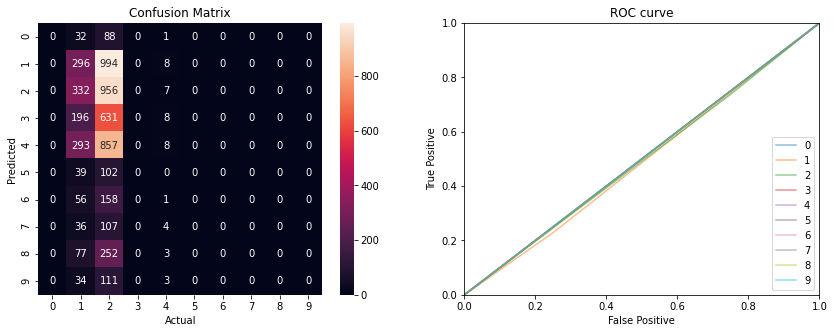

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       121
         1.0       0.21      0.23      0.22      1298
         2.0       0.22      0.74      0.34      1295
         3.0       0.00      0.00      0.00       835
         4.0       0.19      0.01      0.01      1158
         5.0       0.00      0.00      0.00       141
         6.0       0.00      0.00      0.00       215
         7.0       0.00      0.00      0.00       147
         8.0       0.00      0.00      0.00       332
         9.0       0.00      0.00      0.00       148

    accuracy                           0.22      5690
   macro avg       0.06      0.10      0.06      5690
weighted avg       0.14      0.22      0.13      5690



C:\Users\mech\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
y_act,y_pred=r[2],r[3]
plt.figure(figsize=(14,5))
plt.subplot(121)
plot_Matrix_NN(y_act,y_pred)
plt.subplot(122)
plot_ROC_NN(y_act,y_pred)
plt.show()
print(classification_report(y_act, y_pred))

### Testing set 4000

In [13]:
model = tf.keras.models.Sequential(copy.deepcopy(CNNCONFIG))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(XR2, Y2, epochs=5)
test_loss, test_acc = model.evaluate(XRT2,  YT2, verbose=0)
print('\nTest accuracy:', test_acc)
y_pred = np.argmax(model.predict(XRT2), axis=1)

Epoch 1/5
5690/5690 [==============================] - 1s 130us/sample - loss: 1.3100 - acc: 0.5172
Epoch 2/5
5690/5690 [==============================] - 1s 118us/sample - loss: 0.2932 - acc: 0.9183
Epoch 3/5
5690/5690 [==============================] - 1s 125us/sample - loss: 0.1332 - acc: 0.9640
Epoch 4/5
5690/5690 [==============================] - 1s 121us/sample - loss: 0.0851 - acc: 0.9773
Epoch 5/5
5690/5690 [==============================] - 1s 125us/sample - loss: 0.0578 - acc: 0.9852

Test accuracy: 0.95049363


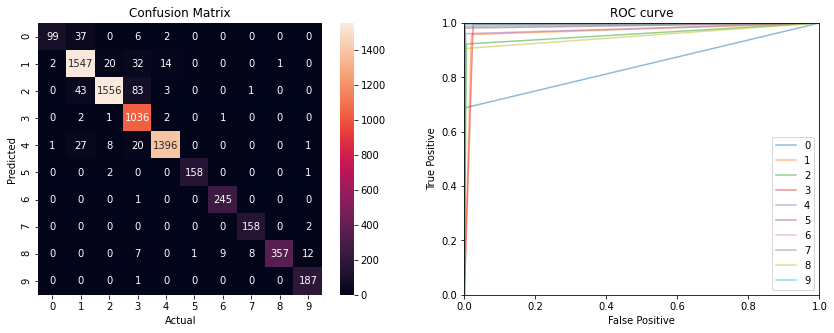

              precision    recall  f1-score   support

           0       0.97      0.69      0.80       144
           1       0.93      0.96      0.95      1616
           2       0.98      0.92      0.95      1686
           3       0.87      0.99      0.93      1042
           4       0.99      0.96      0.97      1453
           5       0.99      0.98      0.99       161
           6       0.96      1.00      0.98       246
           7       0.95      0.99      0.97       160
           8       1.00      0.91      0.95       394
           9       0.92      0.99      0.96       188

    accuracy                           0.95      7090
   macro avg       0.96      0.94      0.94      7090
weighted avg       0.95      0.95      0.95      7090



In [14]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plot_Matrix_NN(YT2,y_pred)
plt.subplot(122)
plot_ROC_NN(YT2,y_pred)
plt.show()
print(classification_report(YT2, y_pred))

## 9000 Split

In [15]:
Y3=Y[4000:]
YP2=Y[:4000]
YT3=np.append(YT,YP2) 
X3=X[4000:] 
XP2=X[:4000]
XT3=np.concatenate((XT,XP2))
XR3=X3.reshape(X3.shape[0],48,48,1)/255
XRT3=XT3.reshape(XT3.shape[0],48,48,1)/255

### K-Fold set 9000

In [16]:
r=KfoldNN(copy.deepcopy(CNNCONFIG),XR3,Y3,k=10,epoch=5)

KFold: [||||||||||]
Epoch 1/5
5121/5121 [==============================] - 1s 140us/sample - loss: 1.9684 - acc: 0.2242
Epoch 2/5
5121/5121 [==============================] - 1s 128us/sample - loss: 1.9430 - acc: 0.2271
Epoch 3/5
5121/5121 [==============================] - 1s 127us/sample - loss: 1.9413 - acc: 0.2300
Epoch 4/5
5121/5121 [==============================] - 1s 126us/sample - loss: 1.9379 - acc: 0.2310
Epoch 5/5
569/569 [==============================] - 0s 89us/sample - loss: 1.9543 - acc: 0.2425

10-Fold Accuracy: 0.2237%


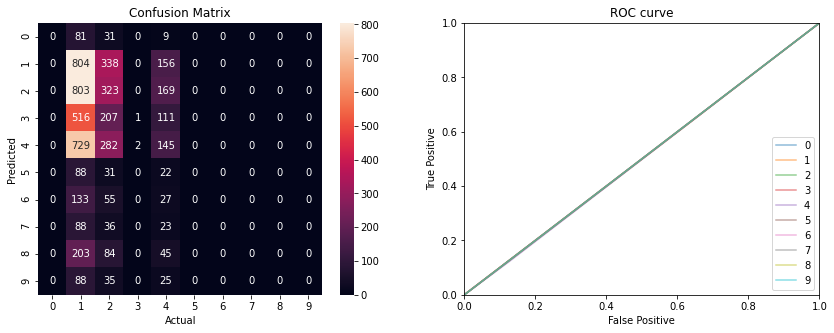

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       121
         1.0       0.23      0.62      0.33      1298
         2.0       0.23      0.25      0.24      1295
         3.0       0.33      0.00      0.00       835
         4.0       0.20      0.13      0.15      1158
         5.0       0.00      0.00      0.00       141
         6.0       0.00      0.00      0.00       215
         7.0       0.00      0.00      0.00       147
         8.0       0.00      0.00      0.00       332
         9.0       0.00      0.00      0.00       148

    accuracy                           0.22      5690
   macro avg       0.10      0.10      0.07      5690
weighted avg       0.19      0.22      0.16      5690



C:\Users\mech\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
y_act,y_pred=r[2],r[3]
plt.figure(figsize=(14,5))
plt.subplot(121)
plot_Matrix_NN(y_act,y_pred)
plt.subplot(122)
plot_ROC_NN(y_act,y_pred)
plt.show()
print(classification_report(y_act, y_pred))

### Testing set 9000

In [18]:
model = tf.keras.models.Sequential(copy.deepcopy(CNNCONFIG))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(XR3, Y3, epochs=5)
test_loss, test_acc = model.evaluate(XRT3,  YT3, verbose=0)
print('\nTest accuracy:', test_acc)
y_pred = np.argmax(model.predict(XRT3), axis=1)

Epoch 1/5
5690/5690 [==============================] - 1s 135us/sample - loss: 1.4034 - acc: 0.4770
Epoch 2/5
5690/5690 [==============================] - 1s 118us/sample - loss: 0.3124 - acc: 0.9081
Epoch 3/5
5690/5690 [==============================] - 1s 121us/sample - loss: 0.1317 - acc: 0.9606
Epoch 4/5
5690/5690 [==============================] - 1s 125us/sample - loss: 0.0877 - acc: 0.9747
Epoch 5/5
5690/5690 [==============================] - 1s 126us/sample - loss: 0.0515 - acc: 0.9866

Test accuracy: 0.9685472


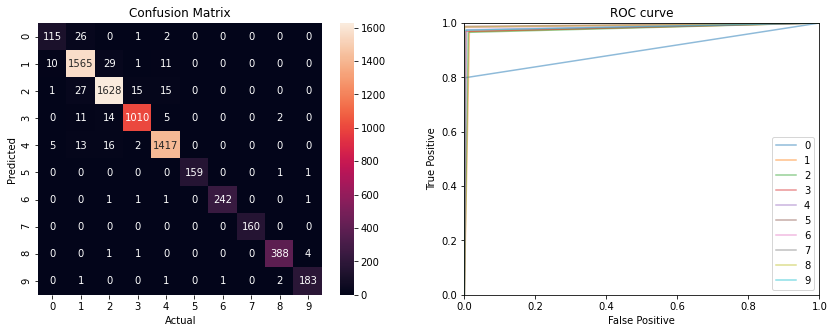

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       144
           1       0.95      0.97      0.96      1616
           2       0.96      0.97      0.96      1686
           3       0.98      0.97      0.97      1042
           4       0.98      0.98      0.98      1453
           5       1.00      0.99      0.99       161
           6       1.00      0.98      0.99       246
           7       1.00      1.00      1.00       160
           8       0.99      0.98      0.99       394
           9       0.97      0.97      0.97       188

    accuracy                           0.97      7090
   macro avg       0.97      0.96      0.97      7090
weighted avg       0.97      0.97      0.97      7090



In [19]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plot_Matrix_NN(YT3,y_pred)
plt.subplot(122)
plot_ROC_NN(YT3,y_pred)
plt.show()
print(classification_report(YT3, y_pred))